In [4437]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4438]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4439]:
import csv

In [4440]:
data = []
atributes = []
labels = []

with open('frequency_data//frequencyFeatures.csv', 'r', newline='') as file:
    reader = csv.reader(file)
    for index, line in enumerate(reader):
        if index == 0:
            atributes = line[1:]
        else:
            if (line[1] not in labels):
                labels.append(line[1])
            data.append(line[1:])

In [4441]:
y = []
X = []
for line in data:
    y.append(labels.index(line[0]))
    X.append([float(s) for s in line[1:]])

In [4442]:
y = torch.tensor(y)
X = torch.tensor(X)

In [4443]:
RANDOM_SEED = 42

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [4444]:
X_tr = X_tr.to(device)
X_te = X_te.to(device)
y_tr = y_tr.to(device)
y_te = y_te.to(device)

In [4445]:
X_tr.shape

torch.Size([1600, 170])

In [4446]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=170, out_features=30),
            nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(in_features=30, out_features=8),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [4447]:
model = Model().to(device)
model

Model(
  (layer_stack): Sequential(
    (0): Linear(in_features=170, out_features=30, bias=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=30, out_features=8, bias=True)
  )
)

In [4448]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [4449]:
def accuracy_fn(y_pred, y_target):
    correct = torch.eq(y_pred, y_target).sum().item()

    return (correct/len(y_pred))*100

In [4450]:
torch.manual_seed(42)

i_count = []
train_loss_values, test_loss_values = [], []
iterations = 1000


for i in range(iterations):
    model.train()

    logits = model(X_tr)
    logits_pred = torch.softmax(logits, dim=1).argmax(dim=1)

    acc = accuracy_fn(y_target=y_tr, y_pred=logits_pred)
    loss = loss_fn(logits, y_tr)
    train_loss_values.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    i_count.append(i)

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_te)
        test_logits_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_te)
        test_loss_values.append(test_loss.item())
        test_acc = accuracy_fn(y_target=y_te, y_pred=test_logits_pred)

    if (i) % 100 == 0:
        print(f'Iteration {i}: TRAIN LOSS: {loss:.5f} | TRAIN ACCURACY: {acc:.1f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.1f}%')

print(f'Iteration {i+1}: TRAIN LOSS: {loss:.5f} | TRAIN ACCURACY: {acc:.2f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.2f}%')


Iteration 0: TRAIN LOSS: 2.15232 | TRAIN ACCURACY: 2.4% | TEST_LOSS: 4.92592 | TEST ACCURACY: 12.5%
Iteration 100: TRAIN LOSS: 0.62429 | TRAIN ACCURACY: 86.5% | TEST_LOSS: 0.68204 | TEST ACCURACY: 81.8%
Iteration 200: TRAIN LOSS: 0.30489 | TRAIN ACCURACY: 92.6% | TEST_LOSS: 0.39435 | TEST ACCURACY: 87.2%
Iteration 300: TRAIN LOSS: 0.19410 | TRAIN ACCURACY: 95.8% | TEST_LOSS: 0.30307 | TEST ACCURACY: 89.0%
Iteration 400: TRAIN LOSS: 0.11638 | TRAIN ACCURACY: 98.6% | TEST_LOSS: 0.24758 | TEST ACCURACY: 91.2%
Iteration 500: TRAIN LOSS: 0.05238 | TRAIN ACCURACY: 99.7% | TEST_LOSS: 0.14119 | TEST ACCURACY: 96.5%
Iteration 600: TRAIN LOSS: 0.02961 | TRAIN ACCURACY: 99.9% | TEST_LOSS: 0.12876 | TEST ACCURACY: 95.0%
Iteration 700: TRAIN LOSS: 0.02110 | TRAIN ACCURACY: 100.0% | TEST_LOSS: 0.09127 | TEST ACCURACY: 97.0%
Iteration 800: TRAIN LOSS: 0.01414 | TRAIN ACCURACY: 99.9% | TEST_LOSS: 0.09698 | TEST ACCURACY: 96.5%
Iteration 900: TRAIN LOSS: 0.01185 | TRAIN ACCURACY: 99.9% | TEST_LOSS: 0.1

In [4451]:
min(test_loss_values)

0.06489326804876328

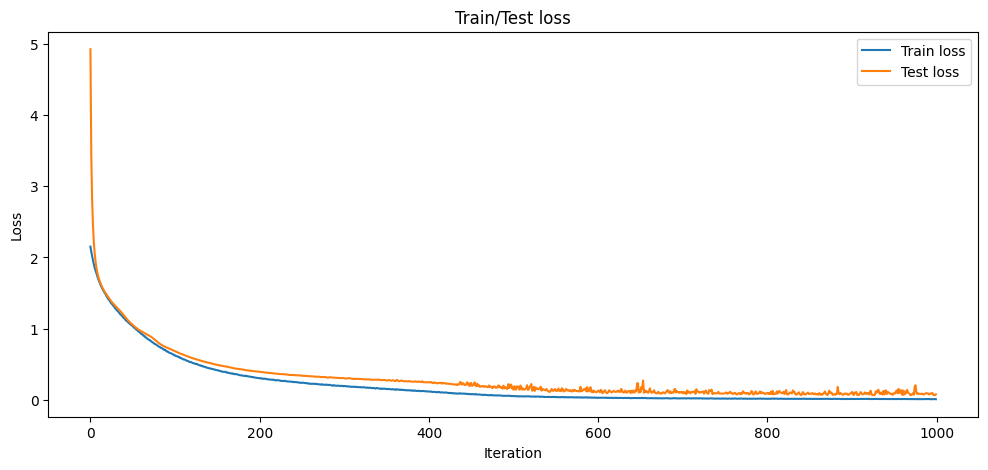

In [4461]:
plt.figure(figsize=(12,5))
plt.plot(i_count, train_loss_values, label='Train loss')
plt.plot(i_count, test_loss_values, label='Test loss')
plt.title("Train/Test loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend();